In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import mannwhitneyu # аналог t-теста Стьюдента, но столь чувствительный к выбросам
from statsmodels.stats.multicomp import pairwise_tukeyhsd # критерий Тьюки - попарное сравнение групп, устойчивoe к множ сравн
from scipy.stats import shapiro # проверка распределения на нормальность - метод Шапира-Уилка
from scipy.stats import levene # проверка гомогенности дисперсий
from scipy.stats import ttest_ind # t-тест Стьюдента
from scipy.stats import f_oneway # 1-факторный ANOVA
from statsmodels.formula.api import ols # 1 для многофакт ANOVA
from statsmodels.stats.anova import anova_lm # 2 для многофакт ANOVA

sns.set(rc={'figure.figsize': (12, 6)}, style='whitegrid')

In [2]:
# Получение данных
# Тестирование фотографий блюд разных размеров в меню при показе пользователю

photo = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_1.csv')

In [3]:
photo.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [4]:
photo_A = photo.query('group=="A"') # 16:9
photo_B = photo.query('group=="B"') # square
photo_C = photo.query('group=="C"') # 12:4

In [4]:
# Проверка на гомогенность дисперсий

levene(photo_A.events, photo_B.events, photo_C.events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [6]:
# Проверка распределений на нормальность

print("A:", round(shapiro(photo_A.events.sample(1000, random_state=17))[1], 3))
print("B:", round(shapiro(photo_B.events.sample(1000, random_state=17))[1], 3))
print("C:", round(shapiro(photo_C.events.sample(1000, random_state=17))[1], 3))

A: 0.096
B: 0.318
C: 0.336


In [7]:
# ANOVA

f_oneway(photo_A.events, photo_B.events, photo_C.events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [8]:
# p-value < 0 ==> есть различия между группами
# используем критерий Тьюки для попарного сравнения групп

print(pairwise_tukeyhsd(photo.events, photo.group))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


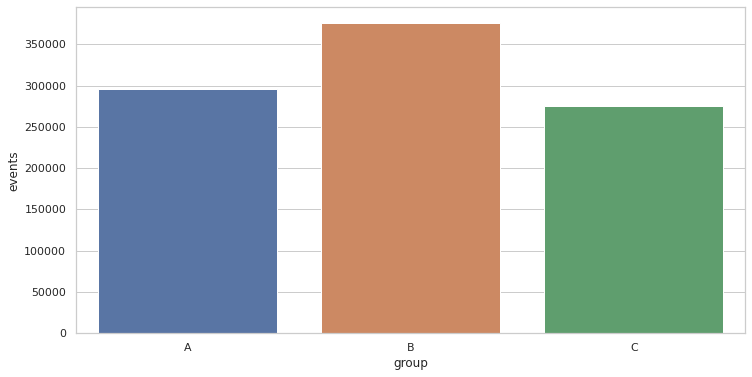

In [9]:
# Все три группы попарно стат значимо отличаются друг от друга
# Решаем какая группа лучше

chart_df = photo.groupby('group', as_index=False).agg({'events':'sum'})

sns.barplot(chart_df.group, chart_df.events);

In [19]:
# Именно вариантом B чаще всего пользовались пользователи, причём различие статзначимо

In [20]:
#  Втором эксперимент - требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента

In [21]:
button = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_2.csv')

In [22]:
button.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


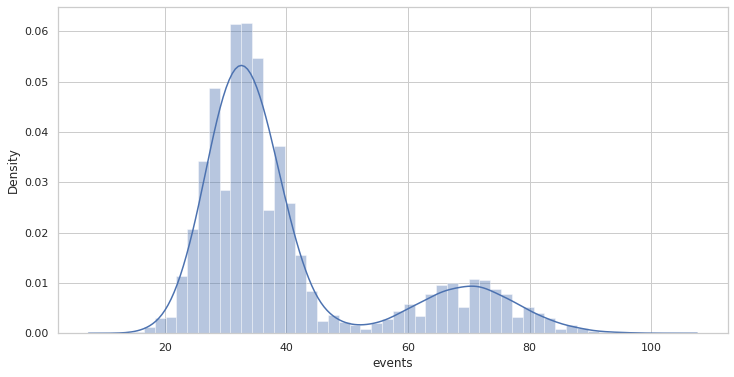

In [23]:
sns.distplot(button.query('group=="test"').events);

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


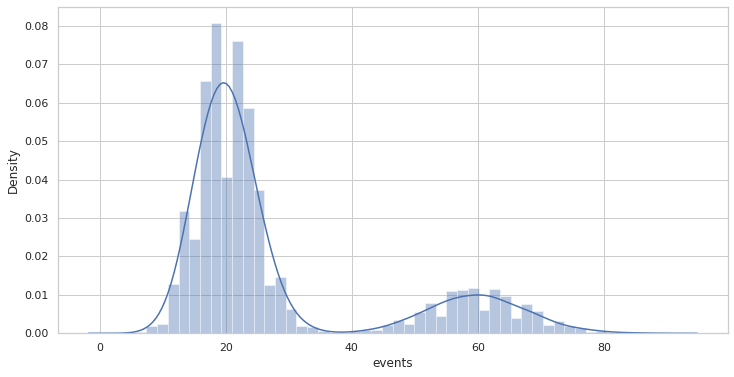

In [24]:
sns.distplot(button.query('group=="control"').events);

In [25]:
button.groupby(['group', 'segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

In [26]:
button.groupby(['group', 'segment']).agg({'events': ['mean', np.std]})

events          
                      mean       std
group   segment                     
control high     59.970800  7.805347
        low      20.031575  4.473576
test    high     69.938500  8.403974
        low      33.025925  5.720845

In [27]:
# Многофакторный ANOVA

formula = 'events ~ group + segment + group:segment'
model = ols(formula, button).fit()
anova_table = anova_lm(model, typ=2)

In [28]:
anova_table

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [29]:
button['combination'] = button.group + ' / ' + button.segment

In [30]:
anova_lm_result = pairwise_tukeyhsd(button.events, button.combination)

print(anova_lm_result)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control / high control / low -39.9392 0.001 -40.1073 -39.7711   True
control / high   test / high   9.9677 0.001   9.7551  10.1803   True
control / high    test / low -26.9449 0.001  -27.113 -26.7768   True
 control / low   test / high  49.9069 0.001  49.7388   50.075   True
 control / low    test / low  12.9944 0.001   12.888  13.1007   True
   test / high    test / low -36.9126 0.001 -37.0807 -36.7445   True
--------------------------------------------------------------------


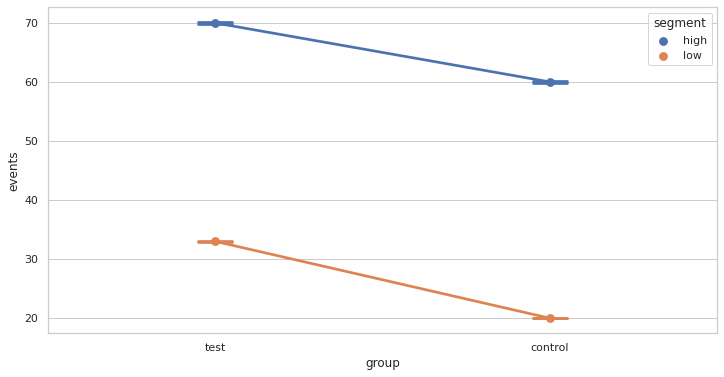

In [31]:
sns.pointplot(x=button.group, y=button.events, hue=button.segment, capsize=0.1);

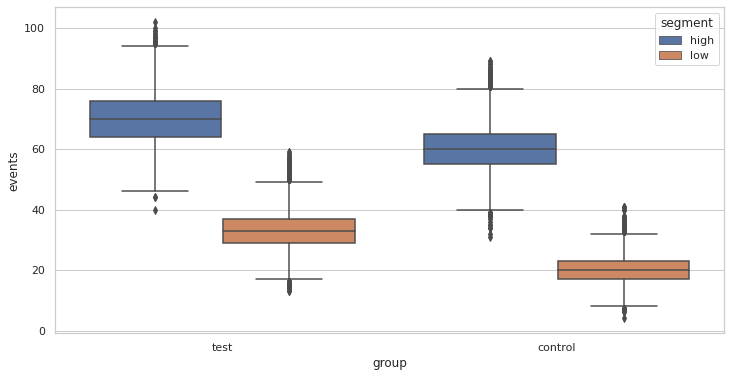

In [32]:
sns.boxplot(x=button.group, y=button.events, hue=button.segment);